In [1]:
%pip install -r requirements.txt
%pip install pyreadline
%config Completer.use_jedi = False
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from gym import wrappers
import torch.optim as optim
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline


Looking in indexes: https://pypi.douban.com/simple/


You should consider upgrading via the '/home/dell/myProjects/dqn/dqn_pytorch_cartpole/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.douban.com/simple/
You should consider upgrading via the '/home/dell/myProjects/dqn/dqn_pytorch_cartpole/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
Env_Name='CartPole-v1'

Batch_Size=64
Replay_Memory_Size=1000000
Target_Network_Update_Frequency=10
Discount_Factor=0.95
Learning_Rate=0.001
Initial_Exploration=1.0
Final_Exploration=0.005
Exploration_Decay=0.9999
Episodes=5000
Hidden_Layer_Size=256


#device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print("device=",device)

env=gym.make(Env_Name).unwrapped
#env=wrappers.Monitor(env,'./tmp/cartpole-v0-0',force=True)
#observation=env.reset()

Input_Shape=env.observation_space.shape[0]
Action_Shape=env.action_space.n
#print('Input Shape=',Input_Shape)
#print('Action Shape=',Action_Shape)


device= cpu


In [3]:

class ReplayMemory:
    def __init__(self,capacity):
        self.capacity=capacity
        self.memory=[]
    def push(self,transition):
        self.memory.append(transition)
        if len(self.memory)>self.capacity:
            del self.memory[0]
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:

# class DQN(nn.Module):
#     def __init__(self,input_shape=4,hidden_layer_shape=Hidden_Layer_Size,action_shape=2):
#         super(DQN,self).__init__()
#         self.l1=nn.Linear(input_shape,hidden_layer_shape)
#         self.l2=nn.Linear(hidden_layer_shape,hidden_layer_shape//2)
#         self.l3=nn.Linear(hidden_layer_shape//2,hidden_layer_shape//2//2)
#         self.l4=nn.Linear(hidden_layer_shape//2//2,hidden_layer_shape//2//2//2)
#         self.l5=nn.Linear(hidden_layer_shape//2//2//2,action_shape)
#     def forward(self,x):
#         x=F.relu(self.l1(x))
#         x=F.relu(self.l2(x))
#         x=F.relu(self.l3(x))
#         x=F.relu(self.l4(x))
#         x=self.l5(x)
#         return x

class DQN(nn.Module):
    def __init__(self,input_shape=4,action_shape=2):
        super(DQN,self).__init__()
        self.l1=nn.Linear(input_shape,50)
        self.l1.weight.data.normal_(0, 0.1) 
        #self.l2=nn.Linear(24,24)
        self.l2=nn.Linear(50,action_shape)
        self.l2.weight.data.normal_(0, 0.1)
    
    def forward(self,x):
        x=self.l1(x)
        x=F.relu(x)
        x=self.l2(x)
        return x

In [5]:

model=DQN(input_shape=Input_Shape,action_shape=Action_Shape).to(device)


memory=ReplayMemory(Replay_Memory_Size)
optimizer=optim.Adam(model.parameters(),Learning_Rate)
steps_done=0
episode_durations=[]


In [6]:
def select_action(state):
    global steps_done
    #sample=random.random()
    sample=np.random.uniform()
   # eps_threshold=Final_Exploration+(Initial_Exploration-Final_Exploration)*math.exp(-1.*steps_done/Exploration_Decay)

    eps_threshold=Initial_Exploration*Exploration_Decay 
    eps_threshold=max(eps_threshold,Final_Exploration)
    steps_done+=1
    if sample>eps_threshold:
        return  model(torch.tensor([state],dtype=torch.float32).to(device)).detach().max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(2)]],dtype=torch.int64).to(device)

In [7]:

def run_episode(e,env):
    state=env.reset()
    steps=0
    while True:
        env.render()
        action=select_action(state)
        next_state,reward,done,_=env.step(action[0,0].item())

        if done:
            reward=-1

        memory.push((torch.tensor([state],dtype=torch.float32).to(device),
                    action.clone().detach(),
                    torch.tensor([next_state],dtype=torch.float32).to(device),
                    torch.tensor([reward],dtype=torch.float32).to(device)))
        learn()
        state=next_state
        steps+=1
        if done:
            print("{2} Episode {0} finished after {1} steps".format(e,steps,'\033[92m' if steps>=195
                                                                    else '\033[99m'))
            episode_durations.append(steps)
            plot_durations()
            break


In [8]:
def learn():
    if len(memory)<Batch_Size:
        return
    transitions=memory.sample(Batch_Size)
    batch_state,batch_action,batch_next_state,batch_reward=zip(*transitions)
    batch_state=(torch.cat(batch_state)).clone().detach()
    batch_action=(torch.cat(batch_action)).clone().detach()
    batch_next_state=(torch.cat(batch_next_state)).clone().detach()
    batch_reward=(torch.cat(batch_reward)).clone().detach()
    current_q_values=model(batch_state).gather(1,batch_action)
    current_q_values=current_q_values.squeeze(1)
    #print("current_q_values=",current_q_values)
    
    max_next_q_values=model(batch_next_state).detach().max(1)[0]
    expected_q_values=batch_reward+(Discount_Factor*max_next_q_values)
   # print("expected_q_values=",expected_q_values)
    loss=F.smooth_l1_loss(current_q_values,expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [9]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated


 Episode 0 finished after 14 steps


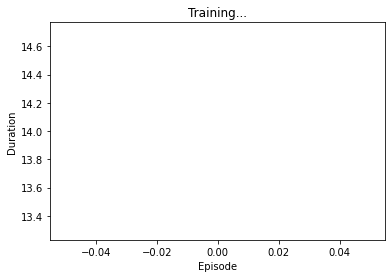

 Episode 1 finished after 20 steps


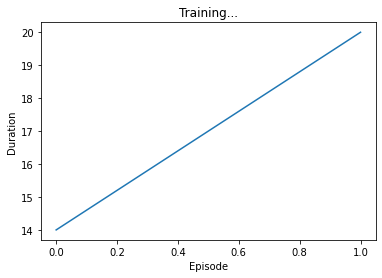

 Episode 2 finished after 53 steps


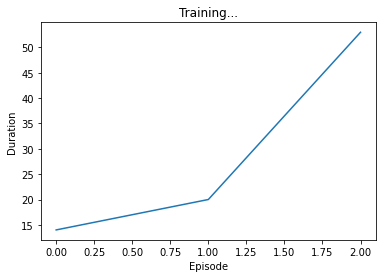

 Episode 3 finished after 13 steps


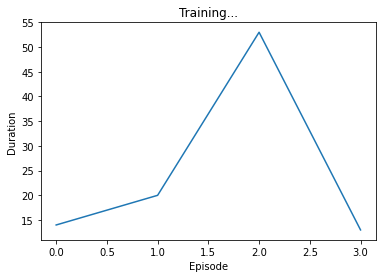

 Episode 4 finished after 18 steps


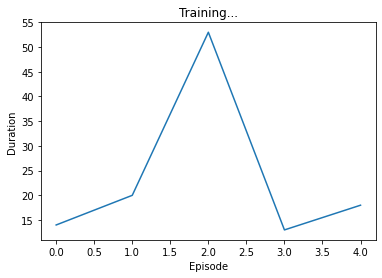

 Episode 5 finished after 14 steps


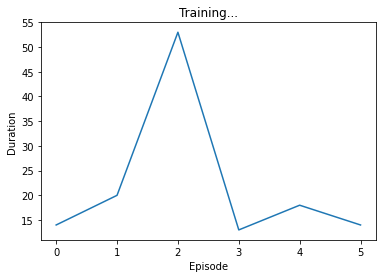

 Episode 6 finished after 13 steps


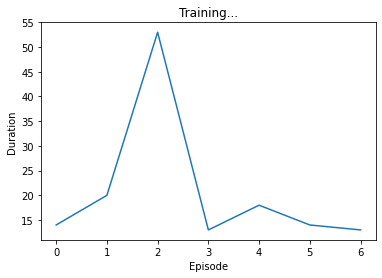

 Episode 7 finished after 50 steps


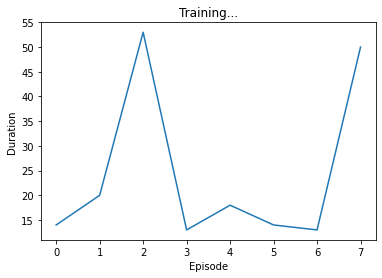

 Episode 8 finished after 17 steps


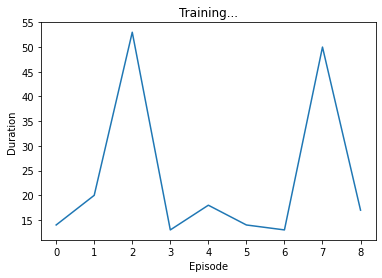

 Episode 9 finished after 15 steps


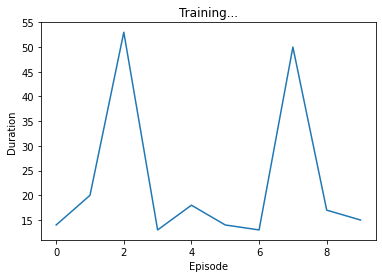

 Episode 10 finished after 28 steps


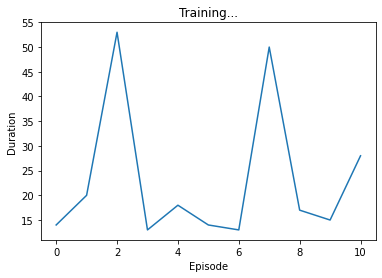

 Episode 11 finished after 9 steps


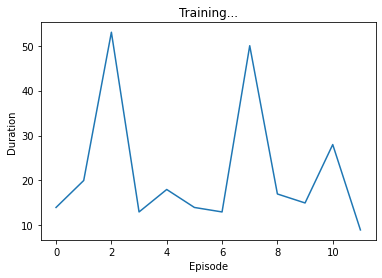

 Episode 12 finished after 40 steps


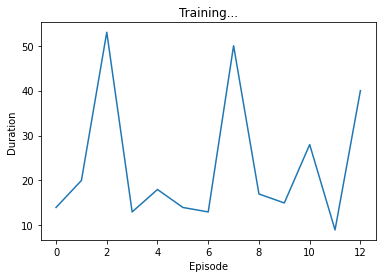

 Episode 13 finished after 18 steps


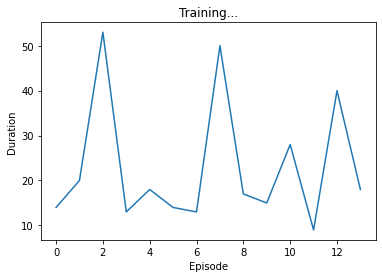

 Episode 14 finished after 28 steps


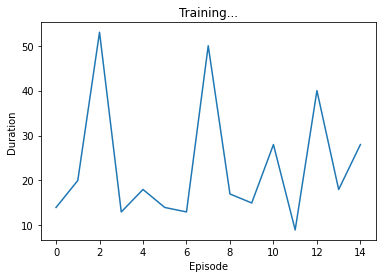

 Episode 15 finished after 13 steps


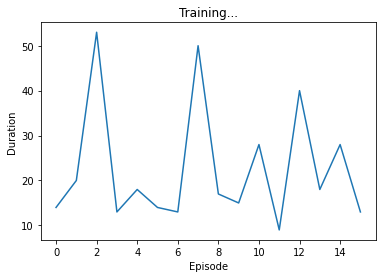

 Episode 16 finished after 12 steps


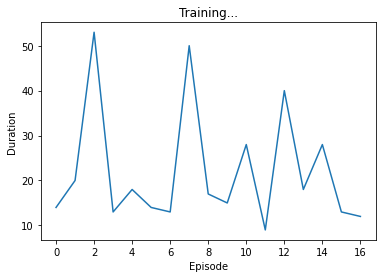

 Episode 17 finished after 14 steps


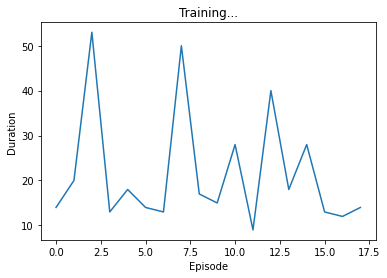

 Episode 18 finished after 34 steps


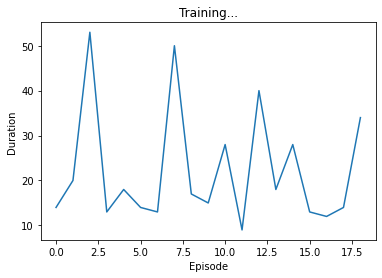

 Episode 19 finished after 29 steps


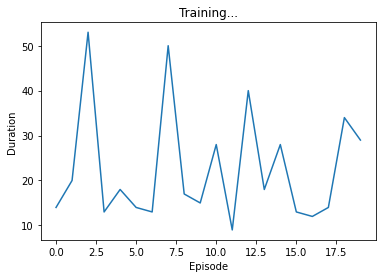

 Episode 20 finished after 22 steps


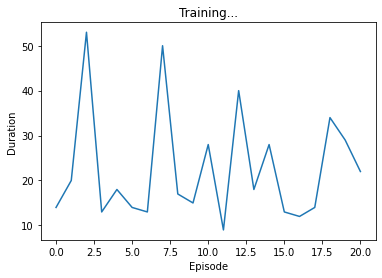

 Episode 21 finished after 28 steps


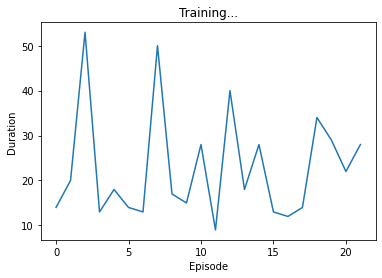

 Episode 22 finished after 18 steps


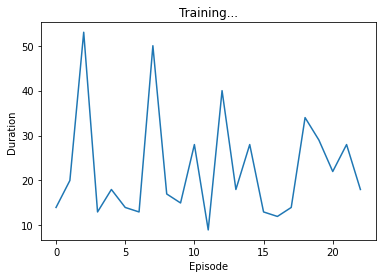

 Episode 23 finished after 24 steps


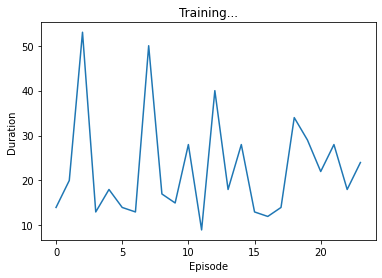

 Episode 24 finished after 21 steps


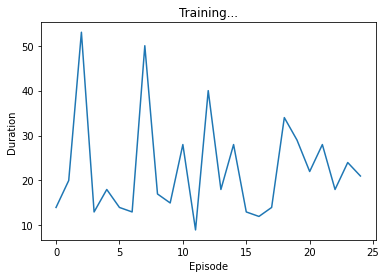

 Episode 25 finished after 12 steps


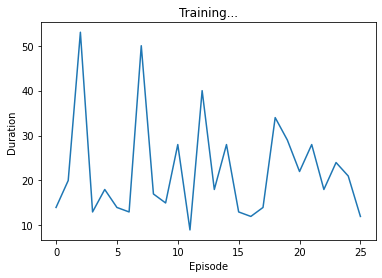

 Episode 26 finished after 23 steps


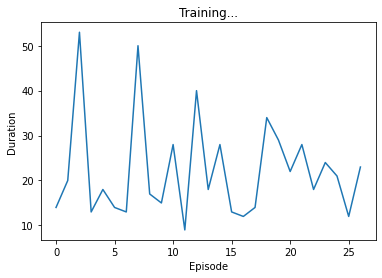

 Episode 27 finished after 12 steps


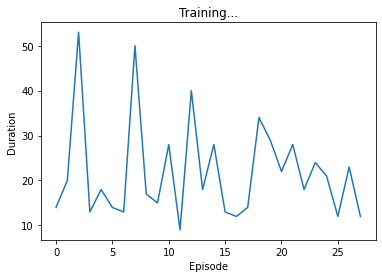

 Episode 28 finished after 18 steps


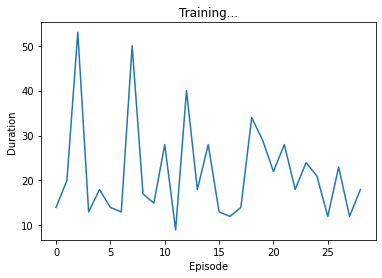

 Episode 29 finished after 12 steps


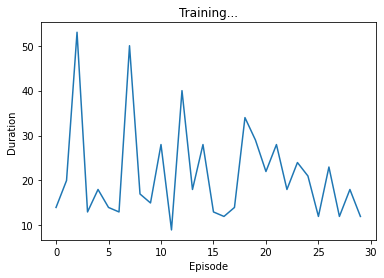

 Episode 30 finished after 16 steps


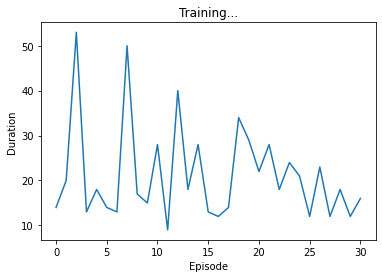

 Episode 31 finished after 13 steps


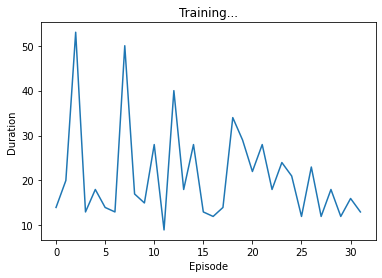

 Episode 32 finished after 23 steps


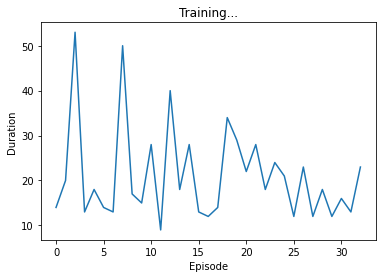

 Episode 33 finished after 20 steps


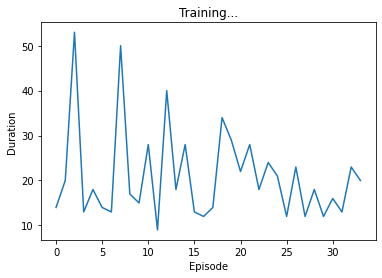

 Episode 34 finished after 16 steps


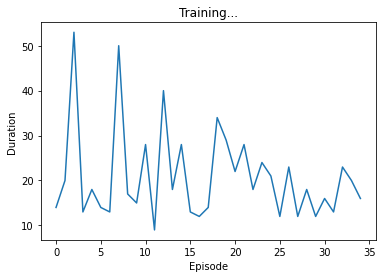

 Episode 35 finished after 9 steps


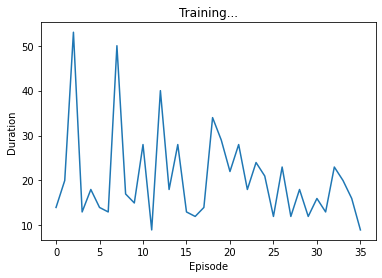

 Episode 36 finished after 14 steps


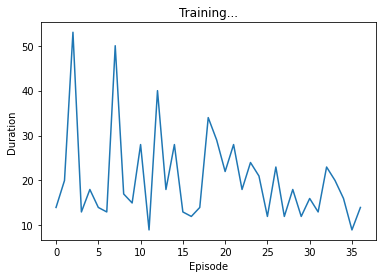

 Episode 37 finished after 21 steps


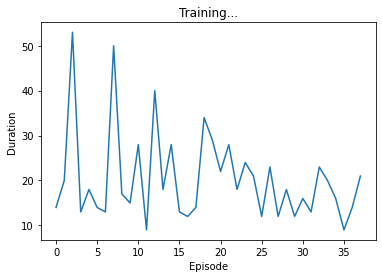

 Episode 38 finished after 25 steps


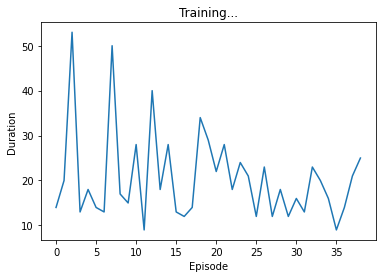

 Episode 39 finished after 26 steps


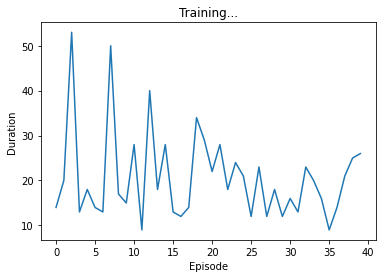

 Episode 40 finished after 13 steps


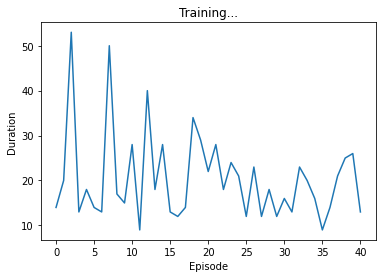

 Episode 41 finished after 28 steps


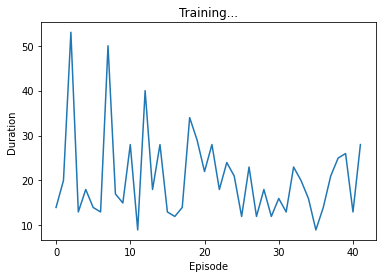

 Episode 42 finished after 10 steps


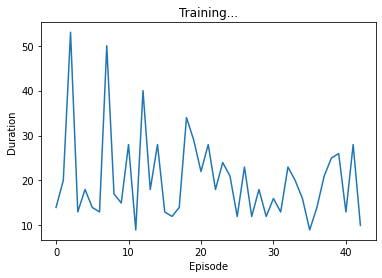

 Episode 43 finished after 13 steps


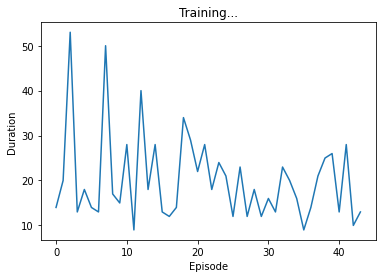

 Episode 44 finished after 33 steps


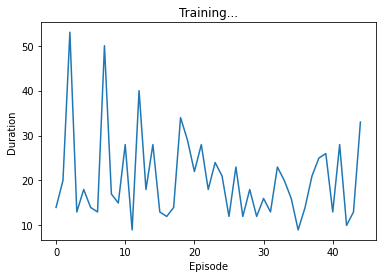

 Episode 45 finished after 10 steps


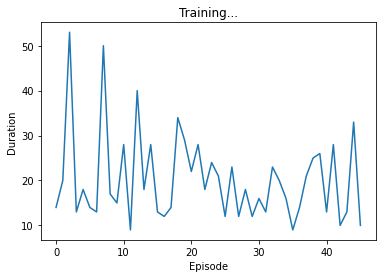

 Episode 46 finished after 20 steps


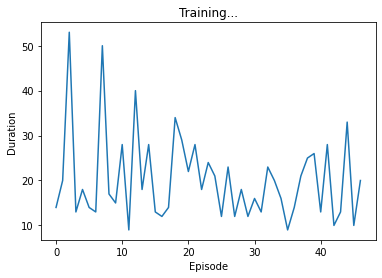

 Episode 47 finished after 34 steps


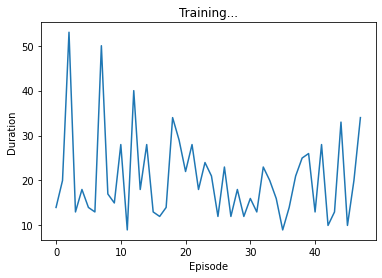

 Episode 48 finished after 23 steps


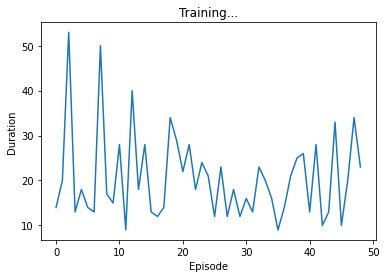

 Episode 49 finished after 28 steps


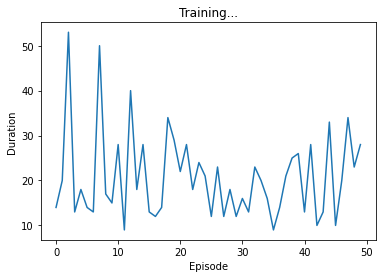

 Episode 50 finished after 13 steps


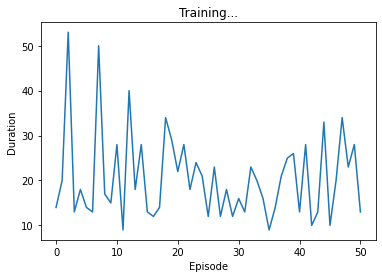

 Episode 51 finished after 11 steps


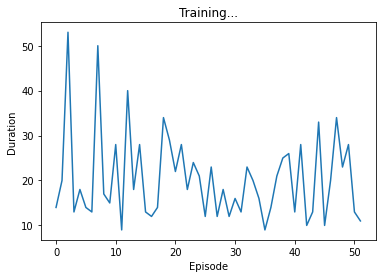

 Episode 52 finished after 18 steps


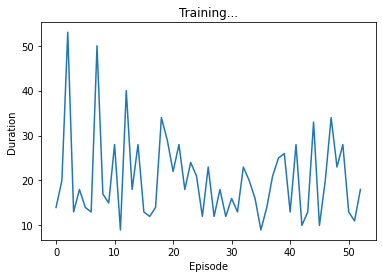

 Episode 53 finished after 26 steps


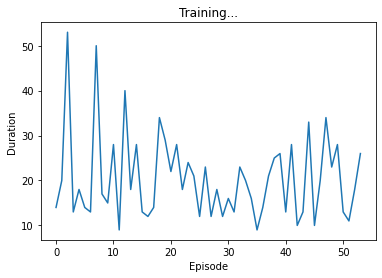

 Episode 54 finished after 69 steps


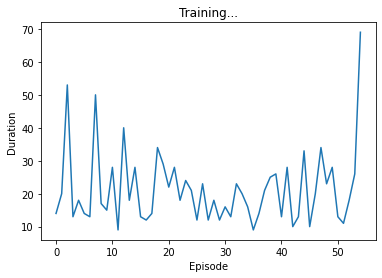

 Episode 55 finished after 18 steps


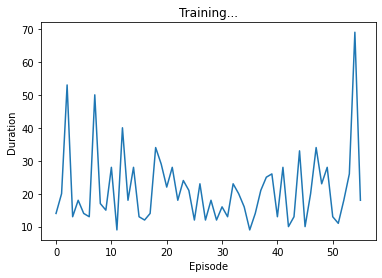

 Episode 56 finished after 11 steps


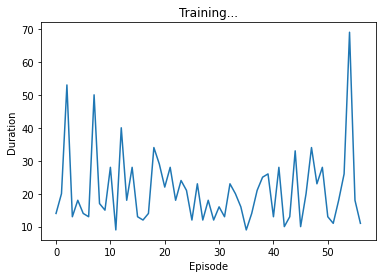

 Episode 57 finished after 15 steps


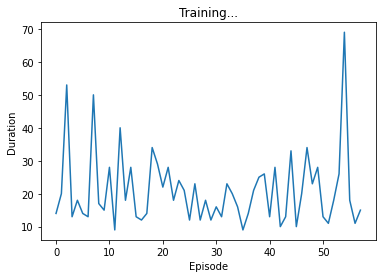

 Episode 58 finished after 19 steps


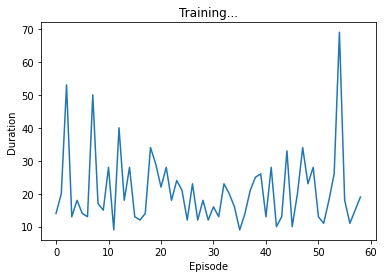

 Episode 59 finished after 24 steps


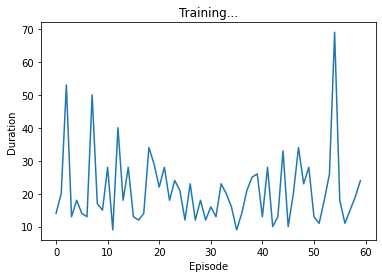

 Episode 60 finished after 13 steps


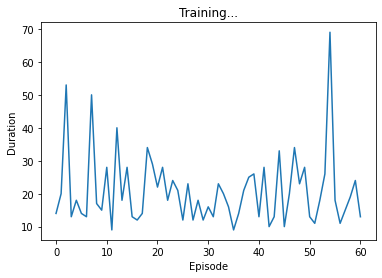

 Episode 61 finished after 28 steps


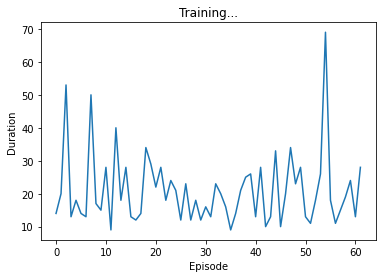

 Episode 62 finished after 64 steps


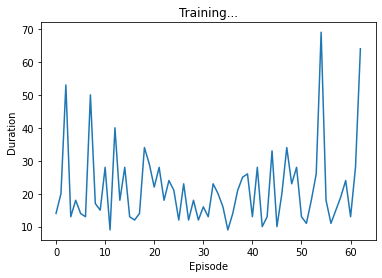

 Episode 63 finished after 20 steps


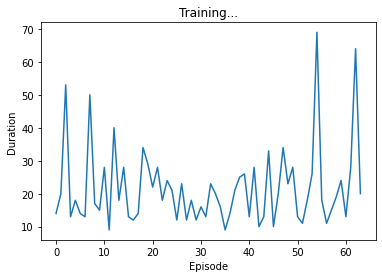

 Episode 64 finished after 24 steps


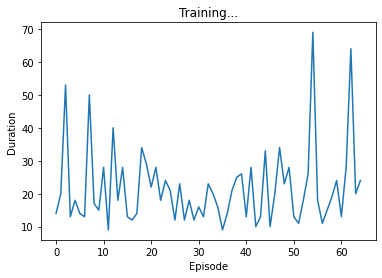

 Episode 65 finished after 20 steps


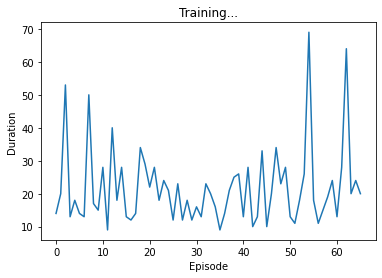

 Episode 66 finished after 18 steps


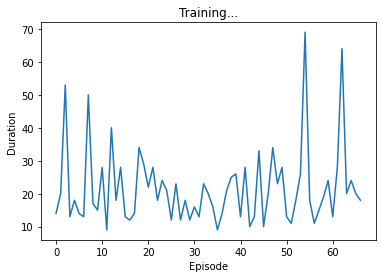

 Episode 67 finished after 12 steps


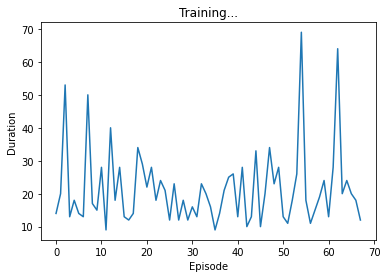

 Episode 68 finished after 25 steps


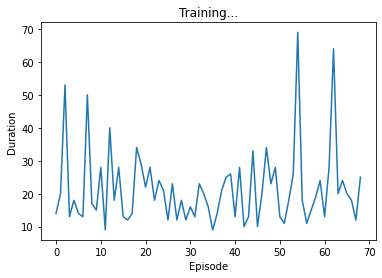

 Episode 69 finished after 9 steps


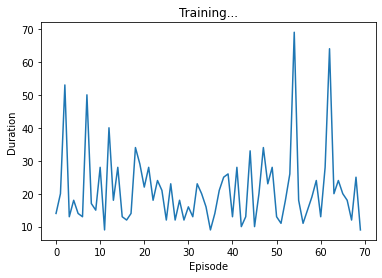

 Episode 70 finished after 12 steps


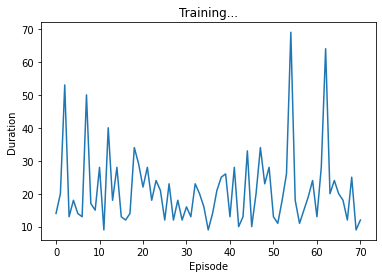

 Episode 71 finished after 24 steps


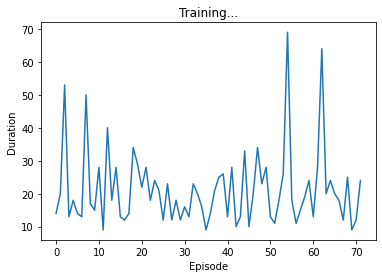

 Episode 72 finished after 17 steps


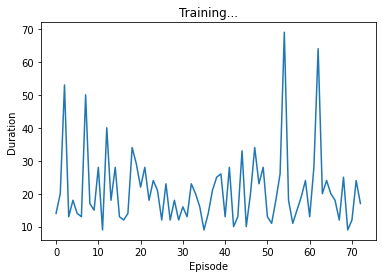

 Episode 73 finished after 14 steps


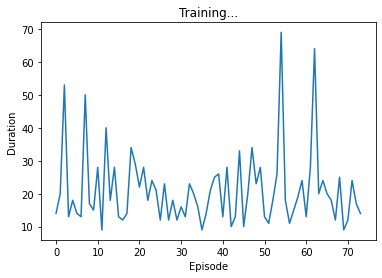

 Episode 74 finished after 23 steps


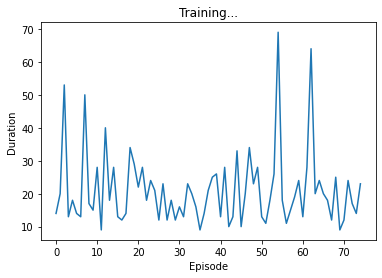

 Episode 75 finished after 13 steps


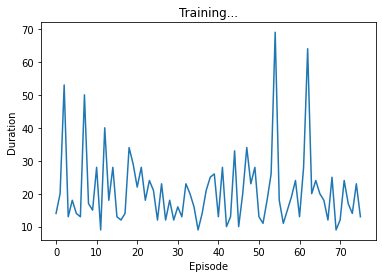

 Episode 76 finished after 17 steps


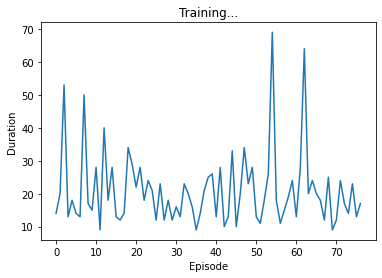

 Episode 77 finished after 34 steps


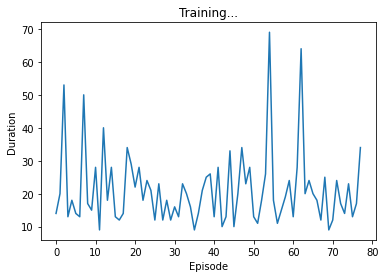

 Episode 78 finished after 32 steps


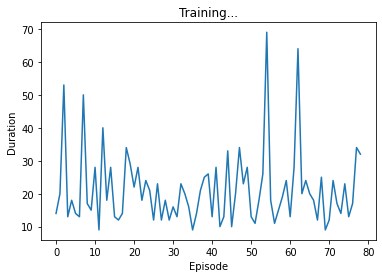

 Episode 79 finished after 30 steps


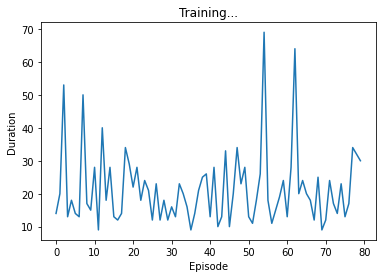

 Episode 80 finished after 30 steps


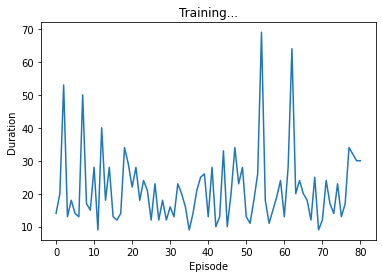

 Episode 81 finished after 34 steps


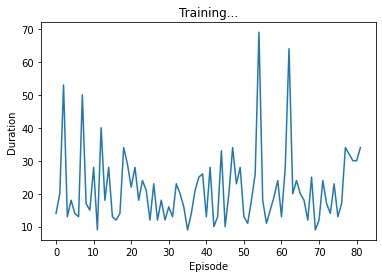

 Episode 82 finished after 38 steps


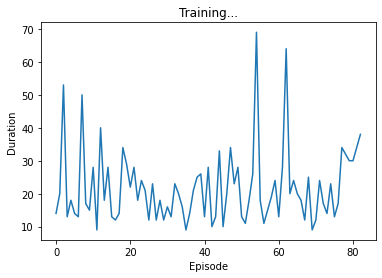

 Episode 83 finished after 16 steps


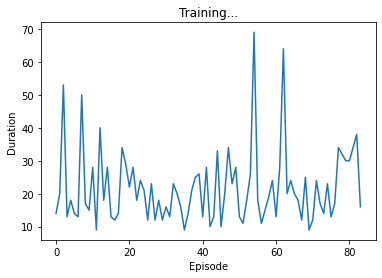

 Episode 84 finished after 35 steps


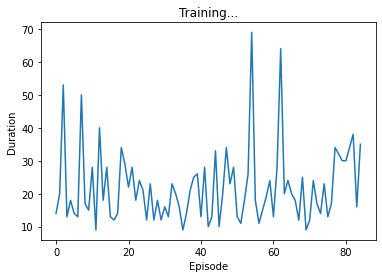

 Episode 85 finished after 12 steps


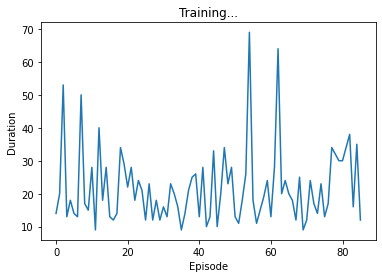

 Episode 86 finished after 23 steps


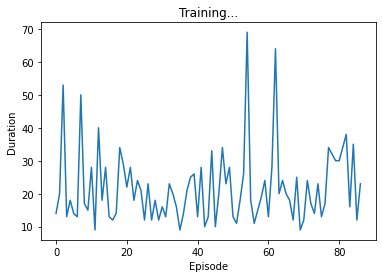

 Episode 87 finished after 10 steps


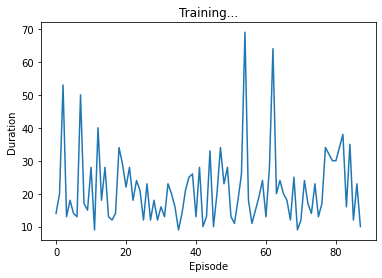

 Episode 88 finished after 29 steps


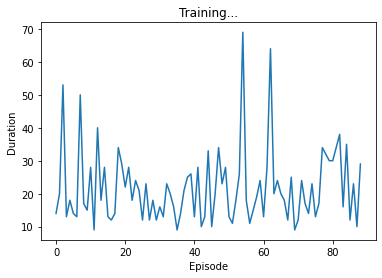

 Episode 89 finished after 16 steps


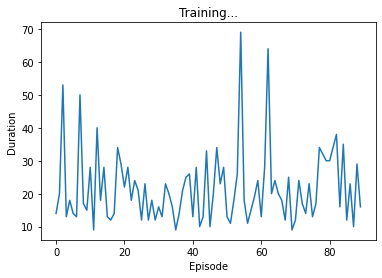

 Episode 90 finished after 28 steps


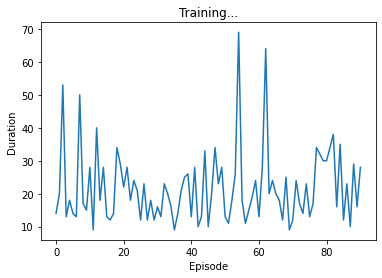

 Episode 91 finished after 12 steps


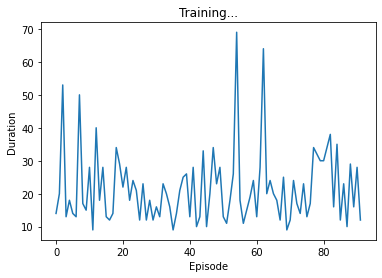

 Episode 92 finished after 25 steps


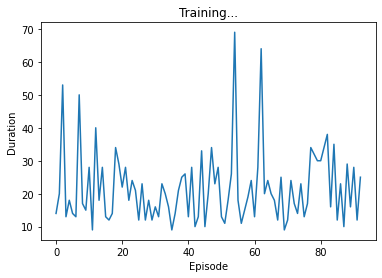

 Episode 93 finished after 42 steps


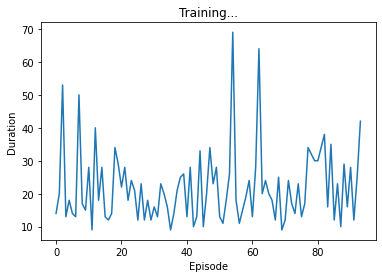

 Episode 94 finished after 11 steps


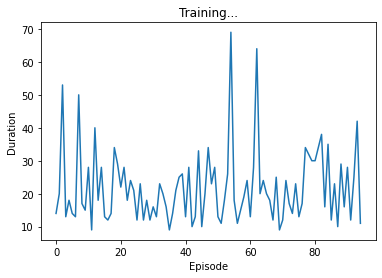

 Episode 95 finished after 32 steps


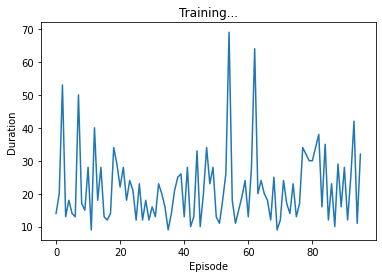

 Episode 96 finished after 9 steps


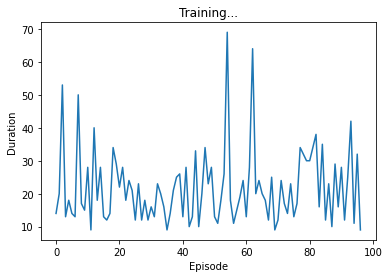

 Episode 97 finished after 14 steps


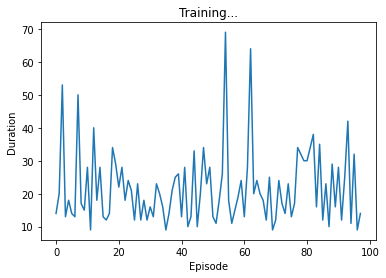

 Episode 98 finished after 11 steps


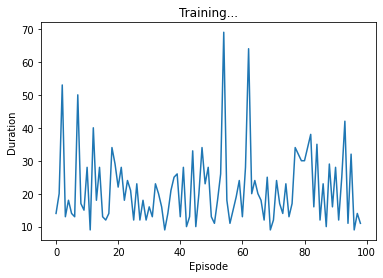

 Episode 99 finished after 15 steps


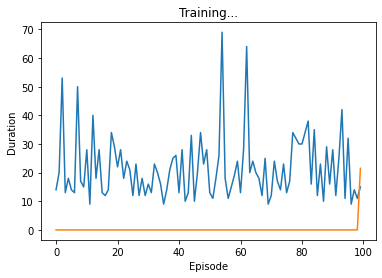

 Episode 100 finished after 14 steps


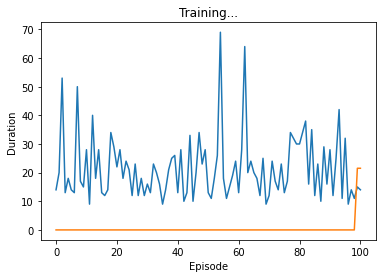

 Episode 101 finished after 13 steps


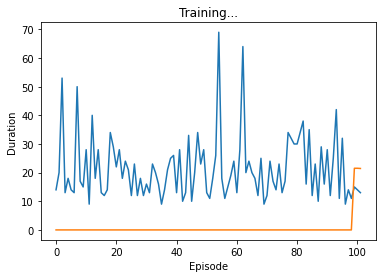

 Episode 102 finished after 36 steps


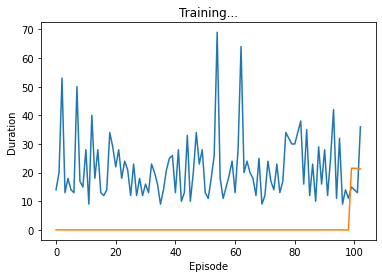

 Episode 103 finished after 16 steps


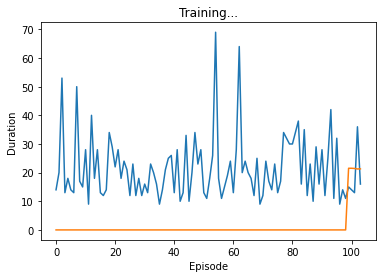

 Episode 104 finished after 14 steps


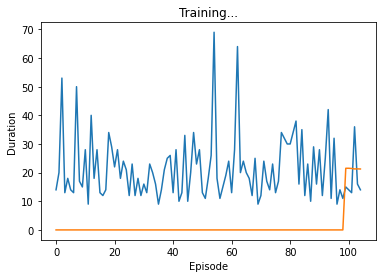

 Episode 105 finished after 15 steps


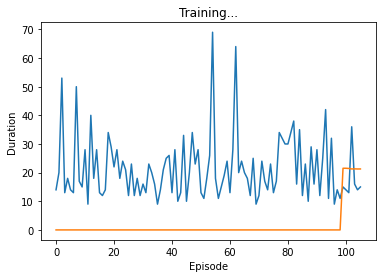

 Episode 106 finished after 33 steps


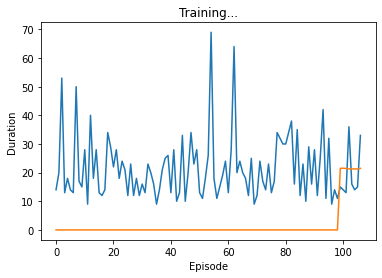

 Episode 107 finished after 13 steps


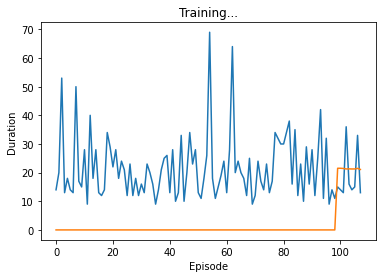

 Episode 108 finished after 15 steps


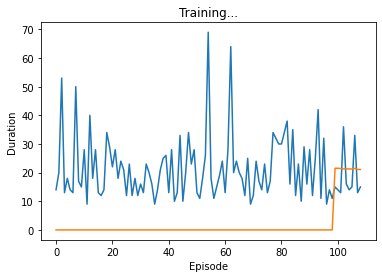

 Episode 109 finished after 24 steps


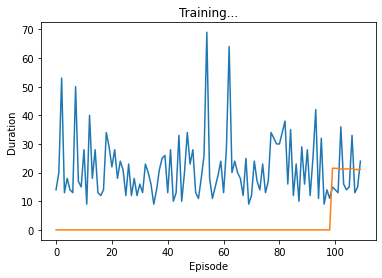

 Episode 110 finished after 22 steps


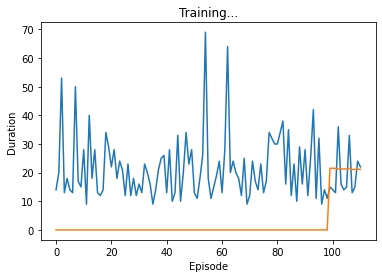

 Episode 111 finished after 16 steps


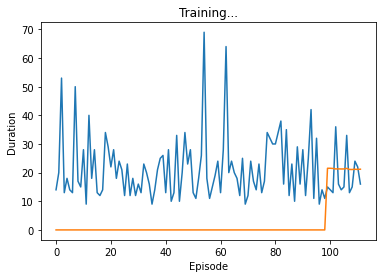

 Episode 112 finished after 16 steps


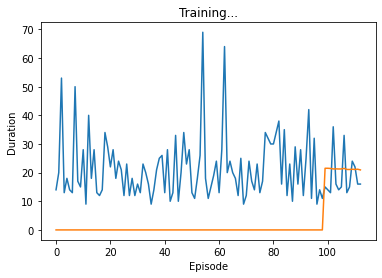

 Episode 113 finished after 43 steps


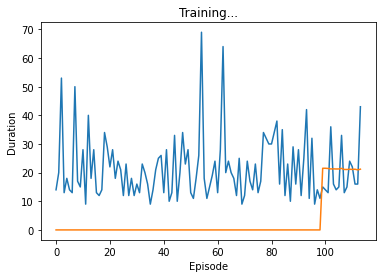

 Episode 114 finished after 16 steps


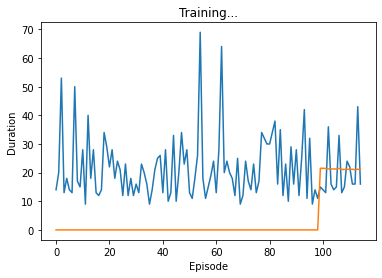

 Episode 115 finished after 12 steps


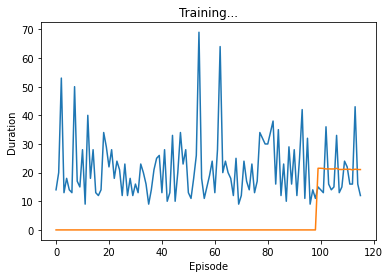

 Episode 116 finished after 11 steps


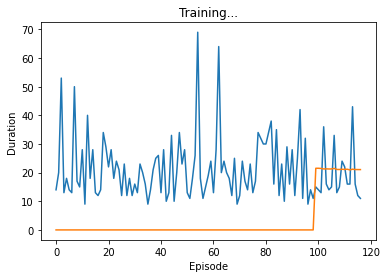

 Episode 117 finished after 38 steps


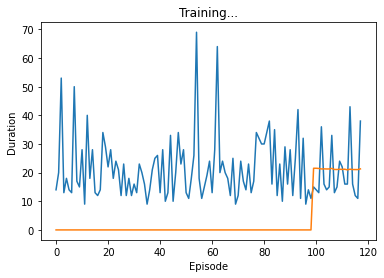

 Episode 118 finished after 11 steps


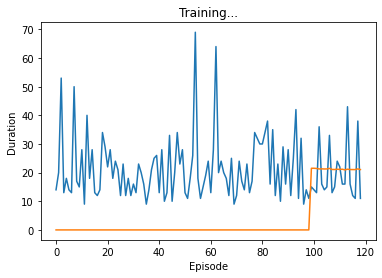

 Episode 119 finished after 23 steps


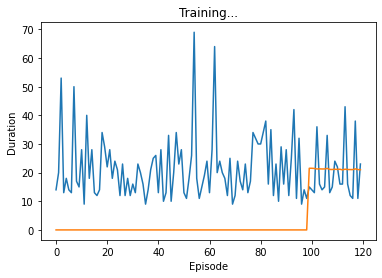

 Episode 120 finished after 33 steps


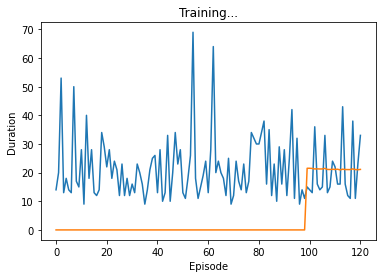

 Episode 121 finished after 17 steps


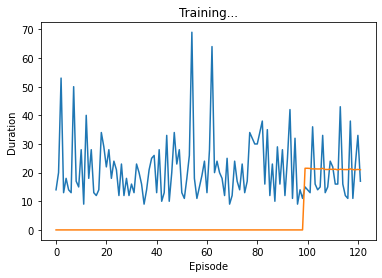

 Episode 122 finished after 21 steps


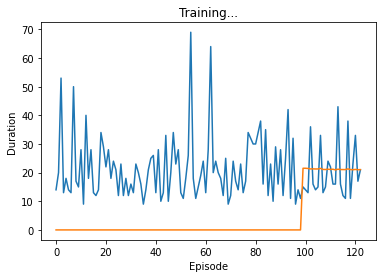

 Episode 123 finished after 19 steps


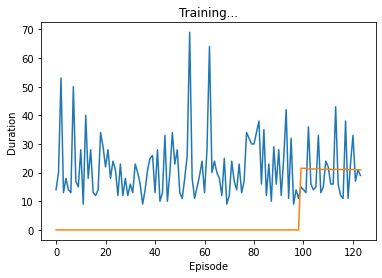

 Episode 124 finished after 14 steps


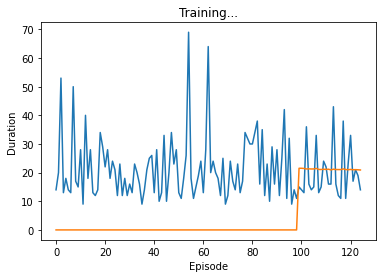

 Episode 125 finished after 14 steps


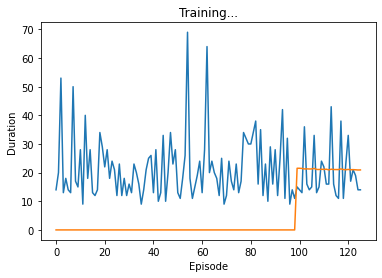

 Episode 126 finished after 14 steps


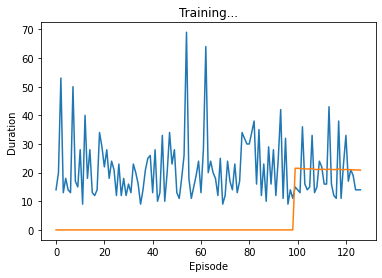

 Episode 127 finished after 20 steps


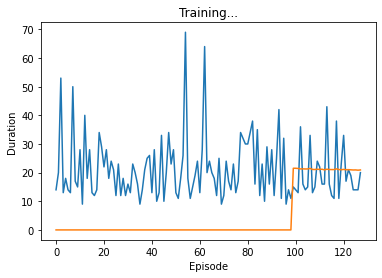

 Episode 128 finished after 20 steps


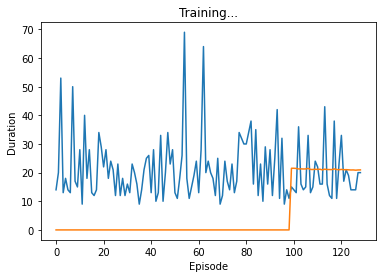

 Episode 129 finished after 25 steps


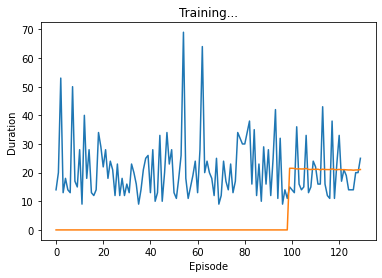

 Episode 130 finished after 12 steps


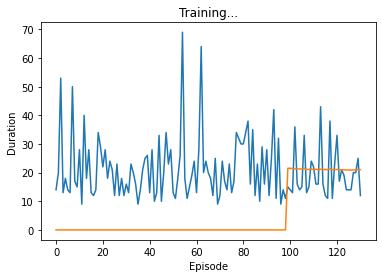

 Episode 131 finished after 15 steps


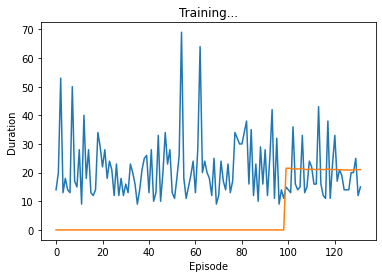

 Episode 132 finished after 31 steps


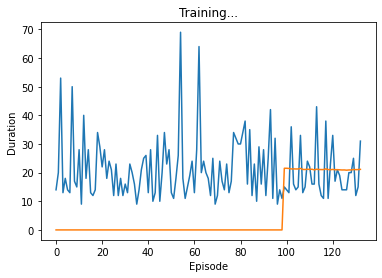

 Episode 133 finished after 29 steps


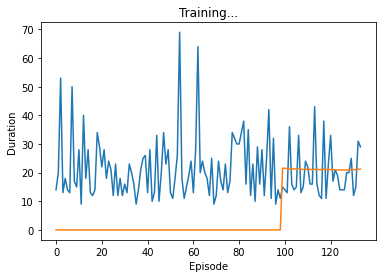

 Episode 134 finished after 18 steps


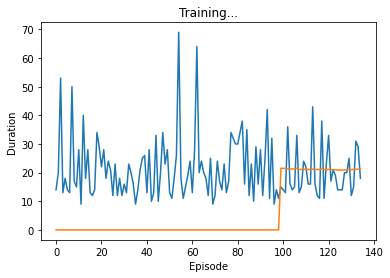

 Episode 135 finished after 15 steps


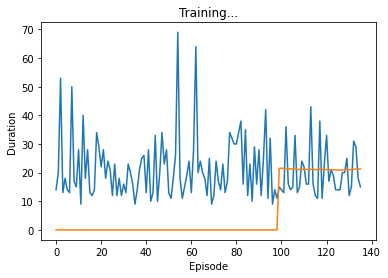

 Episode 136 finished after 27 steps


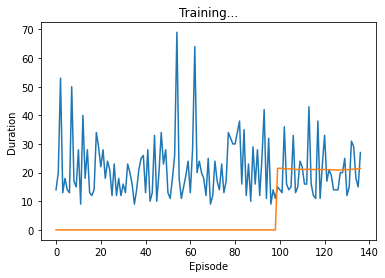

 Episode 137 finished after 19 steps


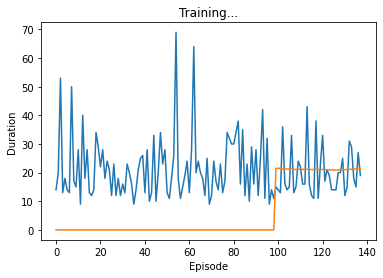

 Episode 138 finished after 12 steps


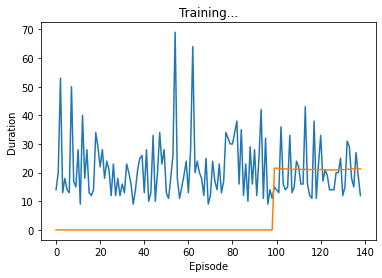

 Episode 139 finished after 21 steps


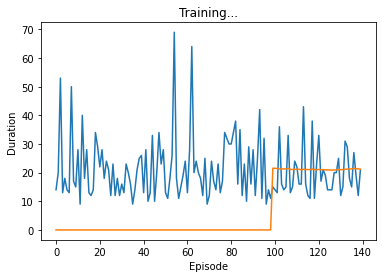

 Episode 140 finished after 33 steps


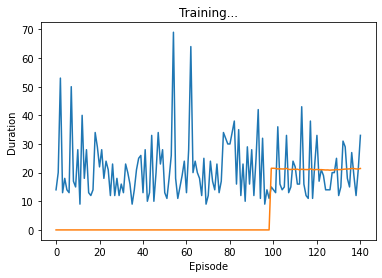

 Episode 141 finished after 11 steps


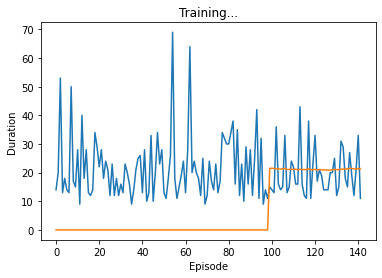

 Episode 142 finished after 17 steps


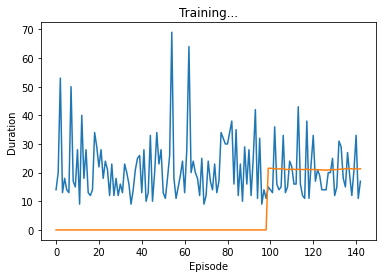

 Episode 143 finished after 12 steps


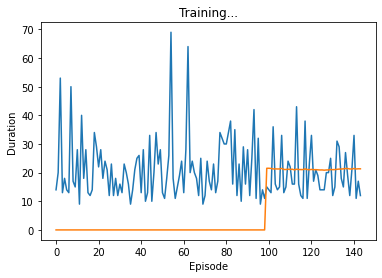

 Episode 144 finished after 22 steps


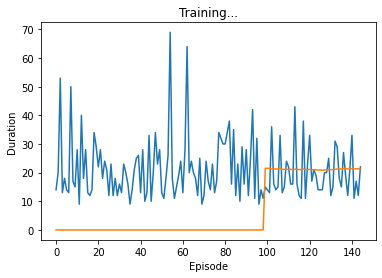

 Episode 145 finished after 15 steps


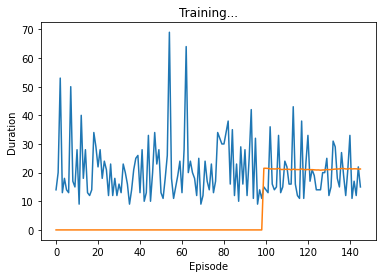

 Episode 146 finished after 46 steps


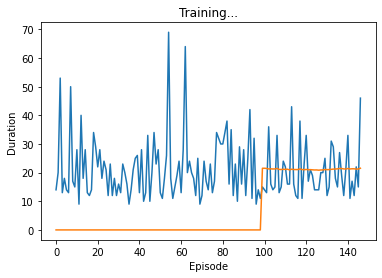

 Episode 147 finished after 16 steps


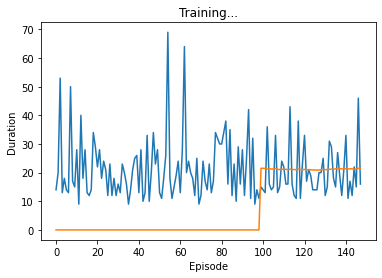

 Episode 148 finished after 20 steps


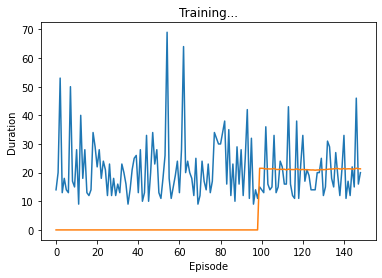

 Episode 149 finished after 22 steps


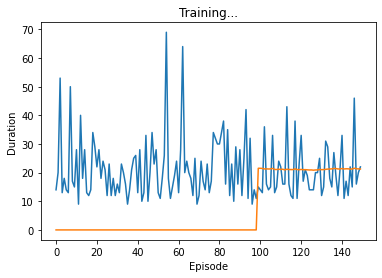

 Episode 150 finished after 20 steps


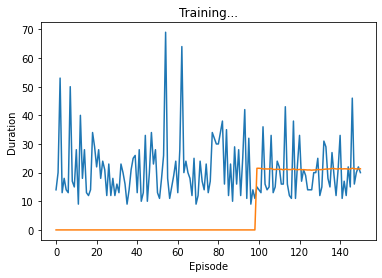

 Episode 151 finished after 25 steps


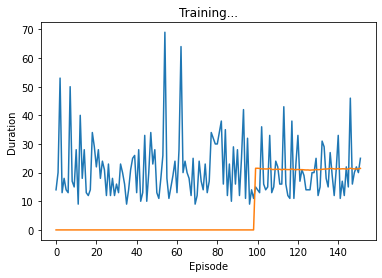

 Episode 152 finished after 21 steps


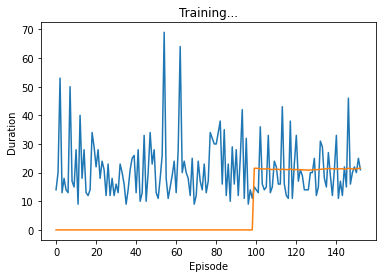

 Episode 153 finished after 19 steps


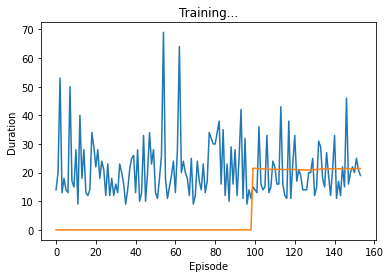

 Episode 154 finished after 13 steps


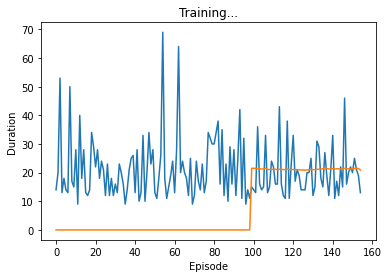

 Episode 155 finished after 8 steps


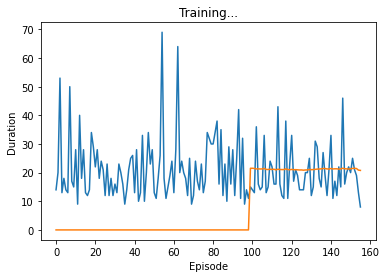

 Episode 156 finished after 11 steps


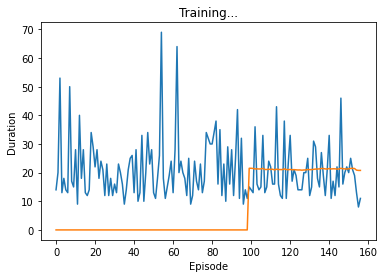

 Episode 157 finished after 18 steps


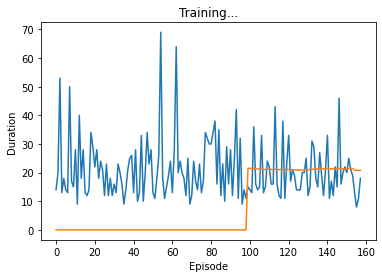

 Episode 158 finished after 25 steps


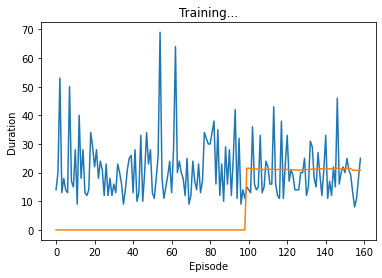

 Episode 159 finished after 14 steps


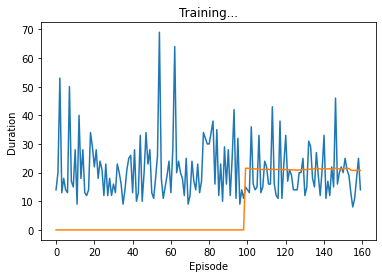

 Episode 160 finished after 27 steps


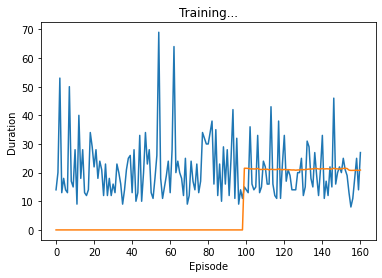

 Episode 161 finished after 18 steps


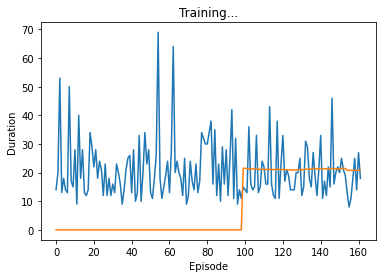

 Episode 162 finished after 13 steps


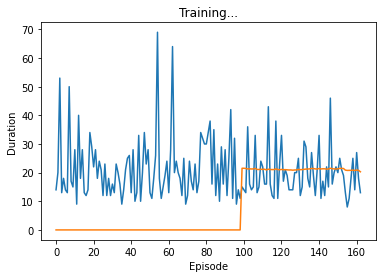

 Episode 163 finished after 13 steps


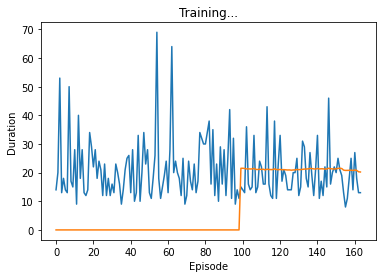

 Episode 164 finished after 23 steps


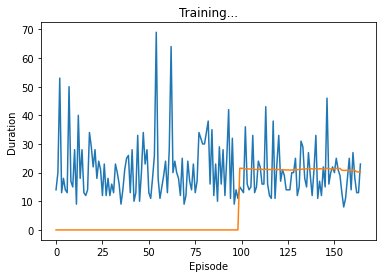

 Episode 165 finished after 16 steps


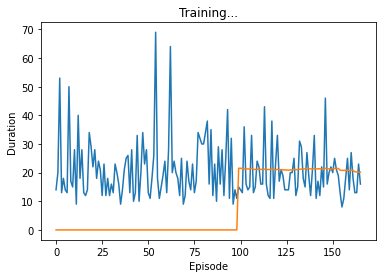

 Episode 166 finished after 18 steps


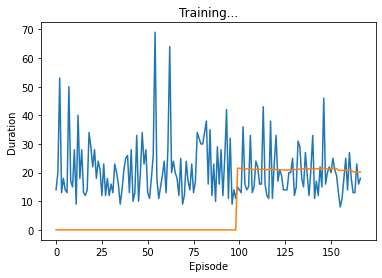

 Episode 167 finished after 25 steps


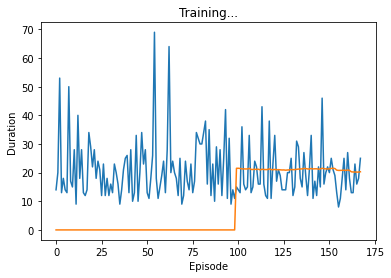

 Episode 168 finished after 28 steps


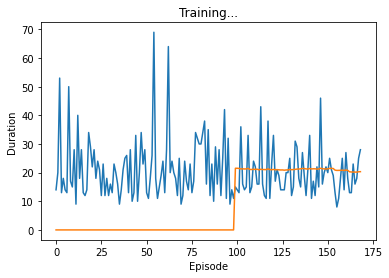

 Episode 169 finished after 22 steps


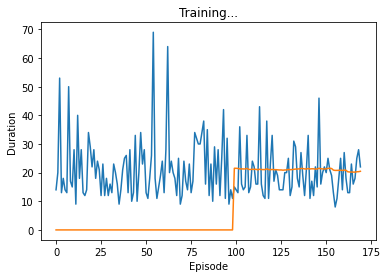

 Episode 170 finished after 43 steps


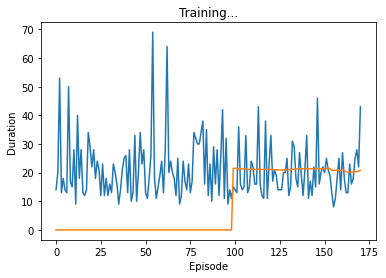

 Episode 171 finished after 37 steps


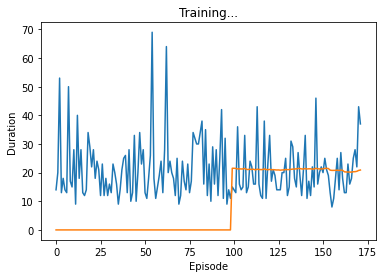

 Episode 172 finished after 10 steps


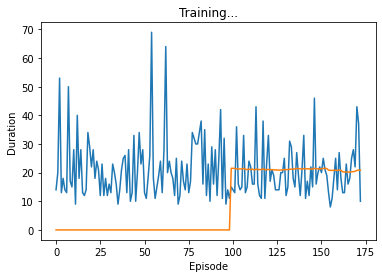

 Episode 173 finished after 17 steps


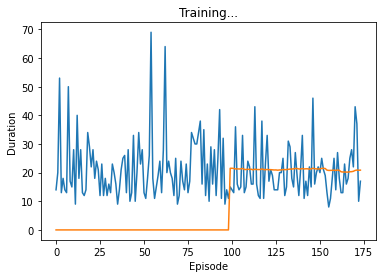

 Episode 174 finished after 11 steps


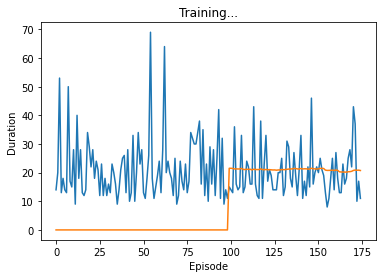

 Episode 175 finished after 21 steps


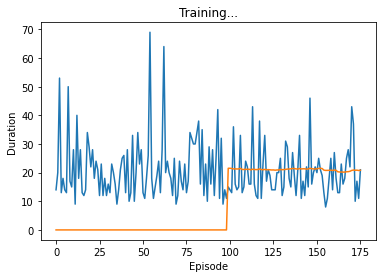

 Episode 176 finished after 22 steps


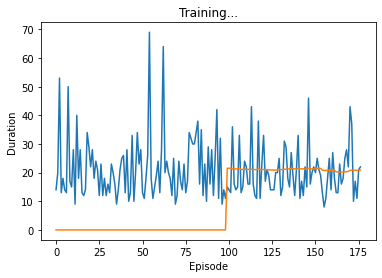

 Episode 177 finished after 21 steps


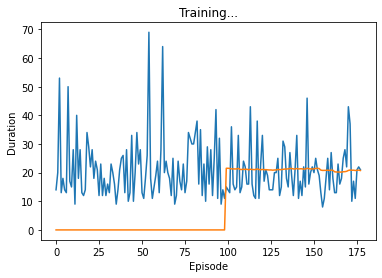

 Episode 178 finished after 31 steps


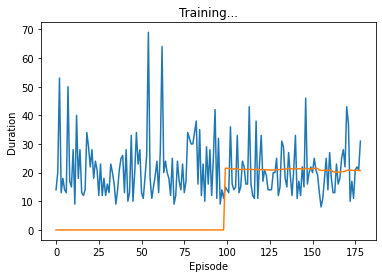

 Episode 179 finished after 52 steps


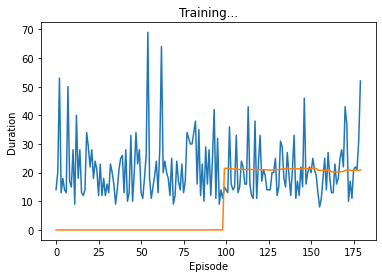

 Episode 180 finished after 22 steps


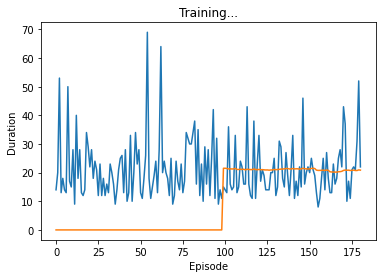

 Episode 181 finished after 15 steps


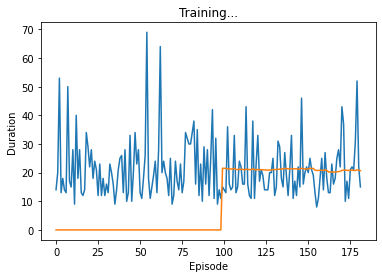

 Episode 182 finished after 16 steps


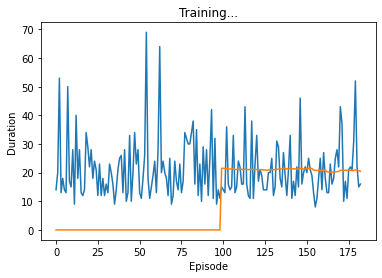

 Episode 183 finished after 37 steps


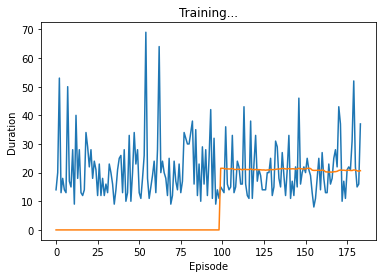

 Episode 184 finished after 25 steps


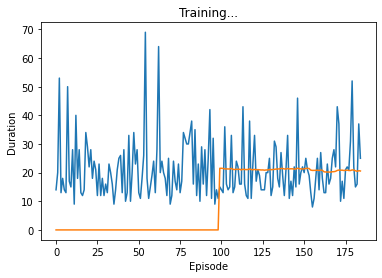

 Episode 185 finished after 12 steps


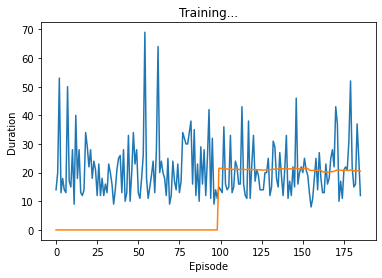

 Episode 186 finished after 13 steps


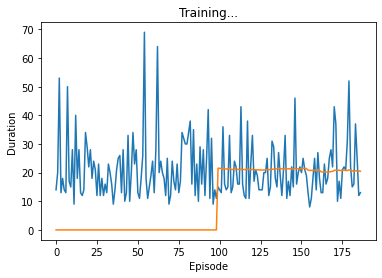

 Episode 187 finished after 17 steps


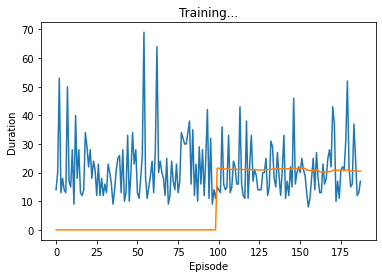

 Episode 188 finished after 15 steps


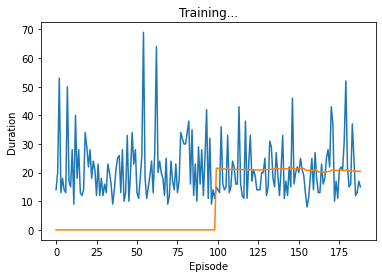

 Episode 189 finished after 52 steps


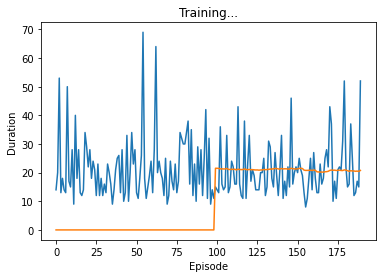

 Episode 190 finished after 15 steps


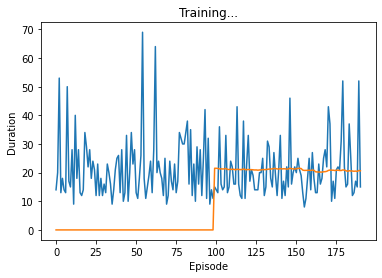

 Episode 191 finished after 12 steps


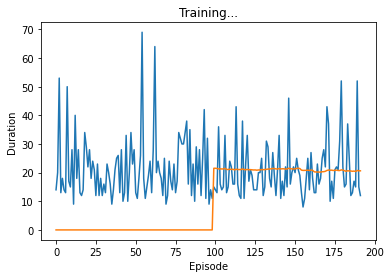

 Episode 192 finished after 17 steps


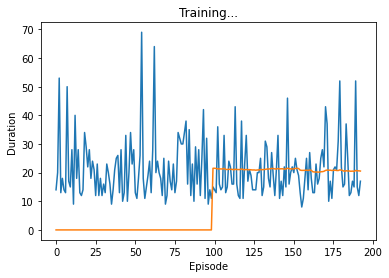

 Episode 193 finished after 30 steps


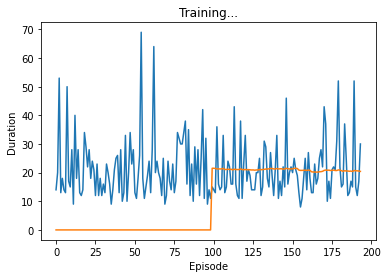

 Episode 194 finished after 12 steps


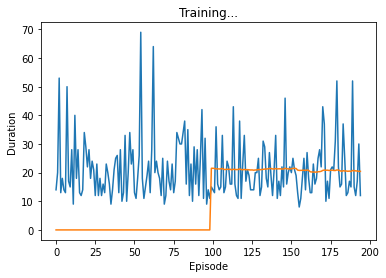

 Episode 195 finished after 56 steps


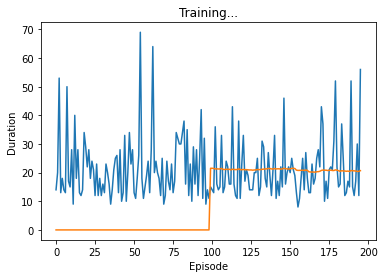

 Episode 196 finished after 10 steps


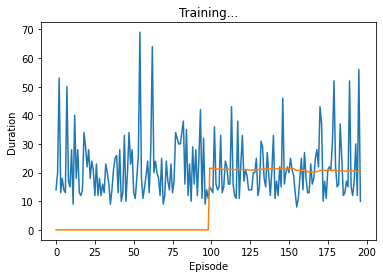

 Episode 197 finished after 21 steps


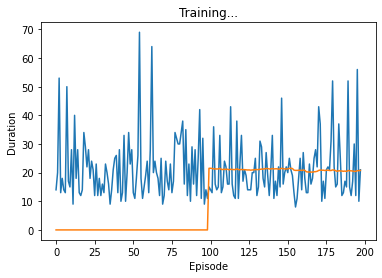

 Episode 198 finished after 45 steps


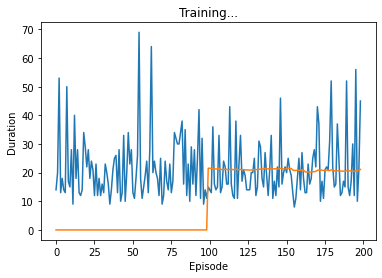

 Episode 199 finished after 21 steps


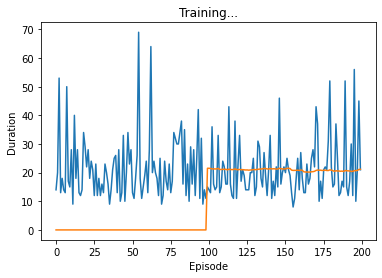

 Episode 200 finished after 24 steps


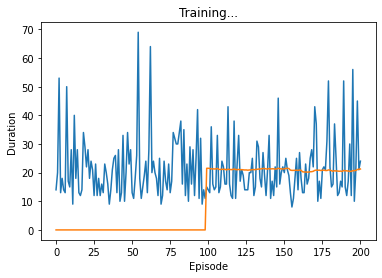

 Episode 201 finished after 14 steps


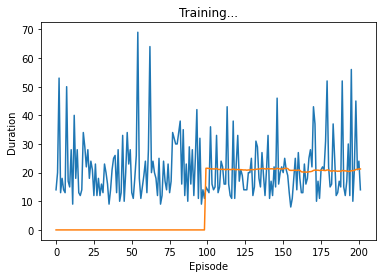

 Episode 202 finished after 18 steps


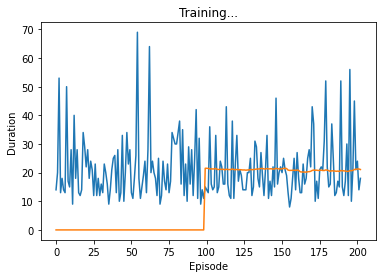

 Episode 203 finished after 13 steps


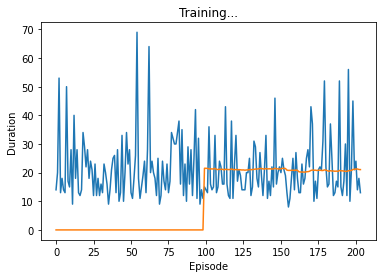

 Episode 204 finished after 15 steps


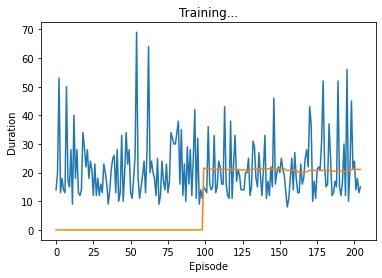

 Episode 205 finished after 14 steps


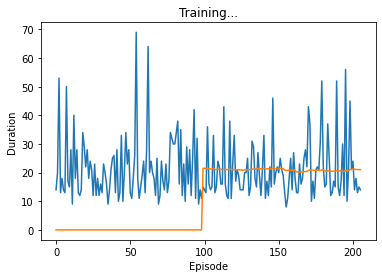

 Episode 206 finished after 29 steps


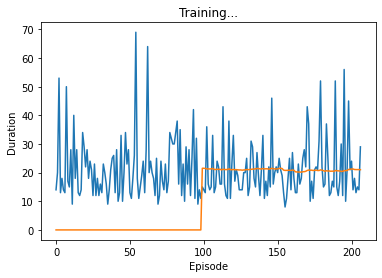

 Episode 207 finished after 30 steps


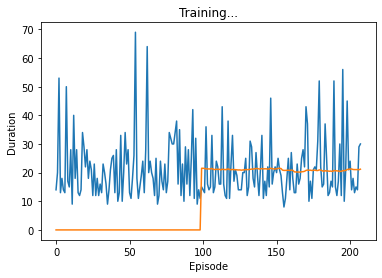

 Episode 208 finished after 14 steps


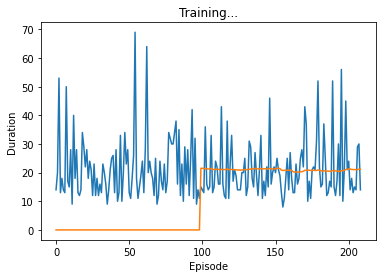

 Episode 209 finished after 30 steps


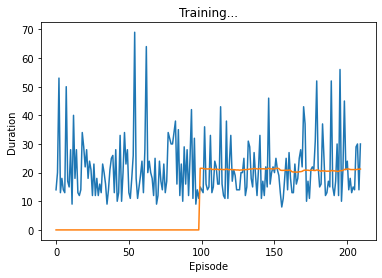

 Episode 210 finished after 11 steps


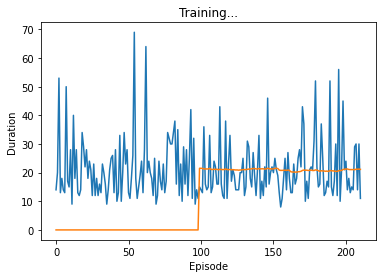

 Episode 211 finished after 12 steps


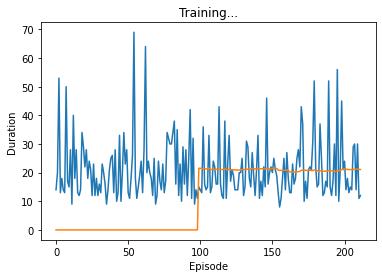

 Episode 212 finished after 15 steps


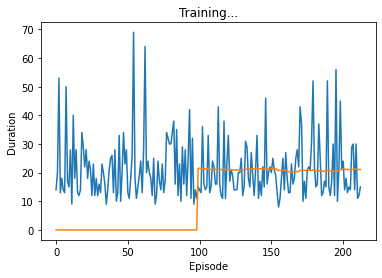

 Episode 213 finished after 15 steps


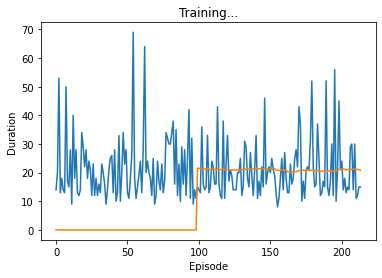

 Episode 214 finished after 18 steps


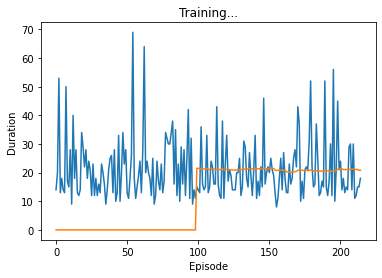

 Episode 215 finished after 26 steps


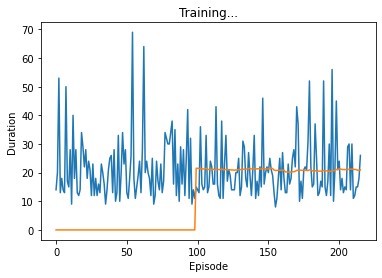

 Episode 216 finished after 15 steps


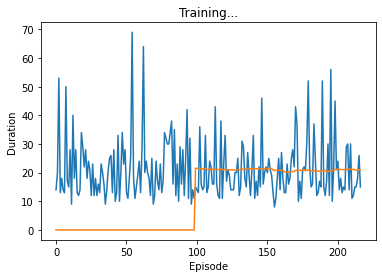

 Episode 217 finished after 20 steps


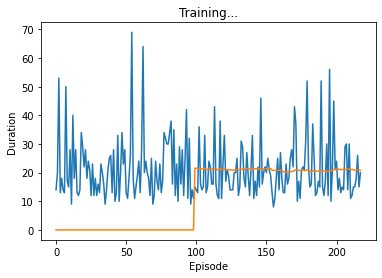

 Episode 218 finished after 24 steps


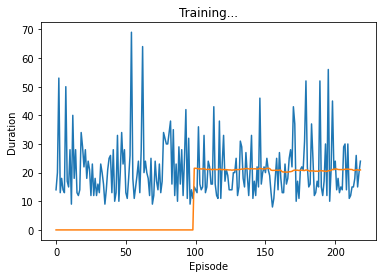

 Episode 219 finished after 17 steps


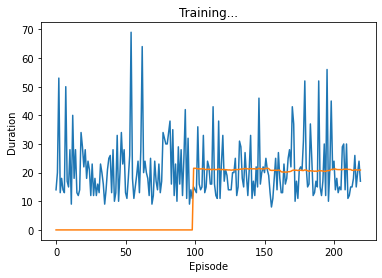

 Episode 220 finished after 30 steps


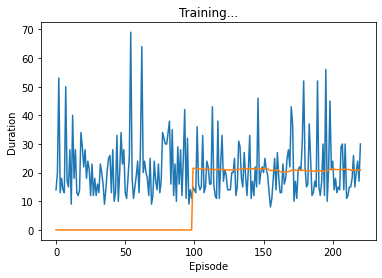

 Episode 221 finished after 12 steps


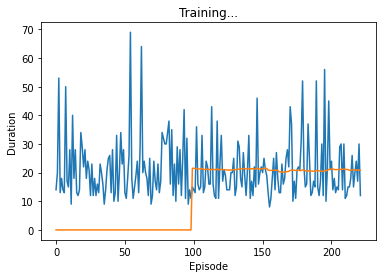

 Episode 222 finished after 11 steps


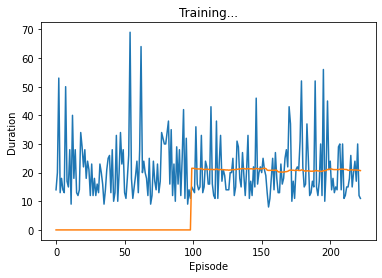

 Episode 223 finished after 21 steps


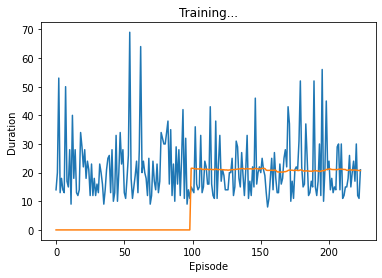

 Episode 224 finished after 46 steps


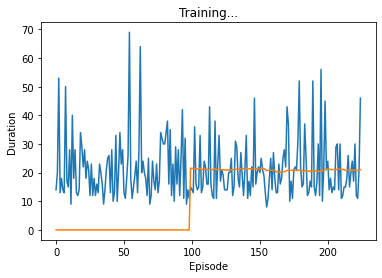

 Episode 225 finished after 19 steps


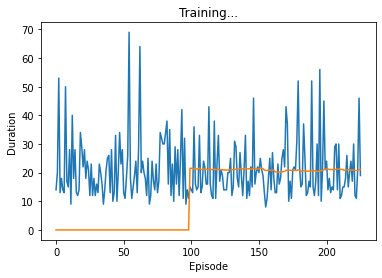

 Episode 226 finished after 15 steps


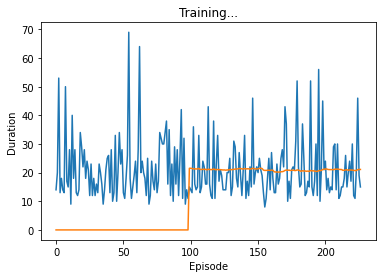

 Episode 227 finished after 15 steps


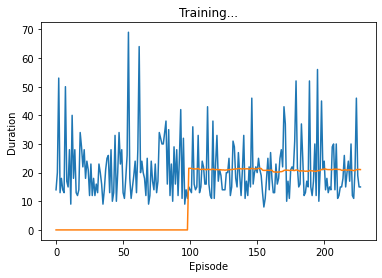

 Episode 228 finished after 16 steps


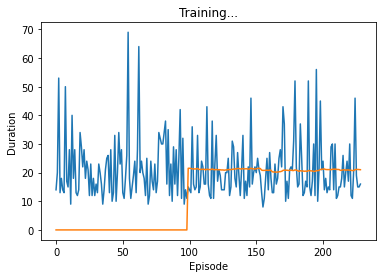

 Episode 229 finished after 13 steps


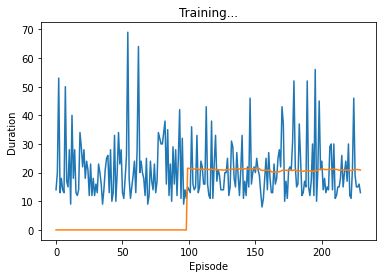

 Episode 230 finished after 13 steps


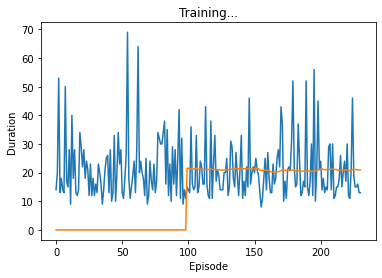

 Episode 231 finished after 33 steps


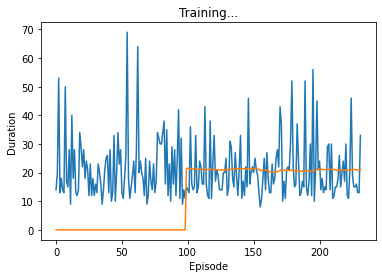

 Episode 232 finished after 19 steps


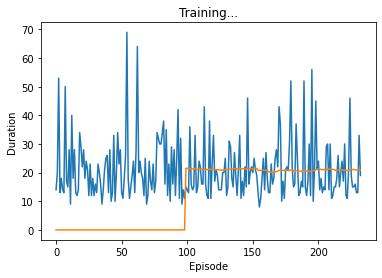

 Episode 233 finished after 23 steps


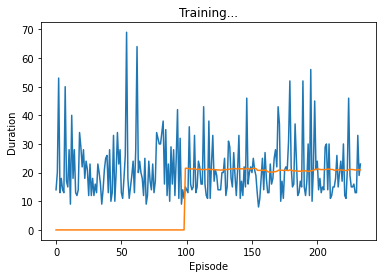

 Episode 234 finished after 16 steps


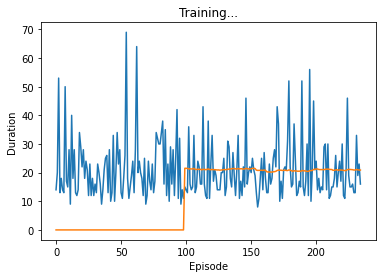

 Episode 235 finished after 36 steps


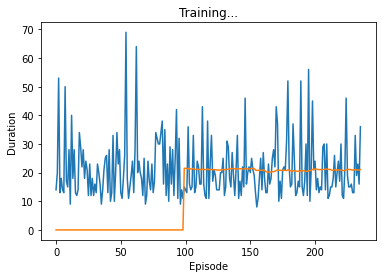

 Episode 236 finished after 52 steps


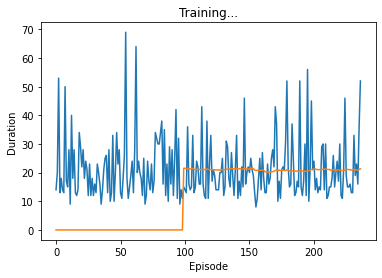

 Episode 237 finished after 19 steps


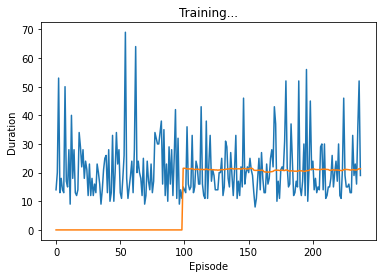

 Episode 238 finished after 22 steps


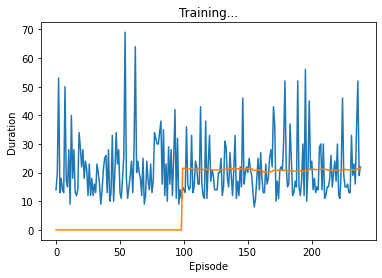

 Episode 239 finished after 20 steps


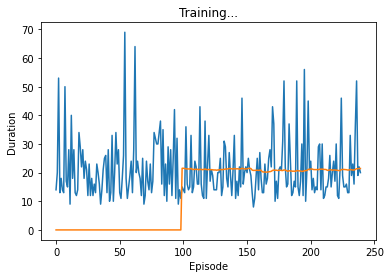

 Episode 240 finished after 27 steps


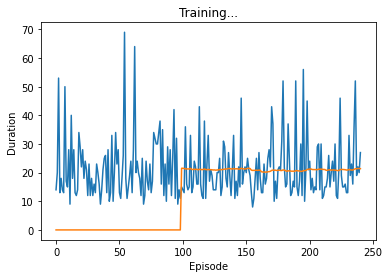

 Episode 241 finished after 15 steps


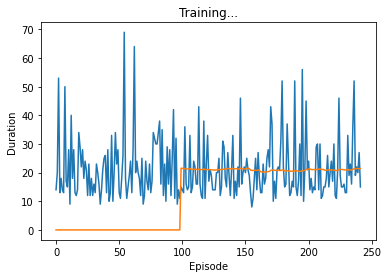

 Episode 242 finished after 16 steps


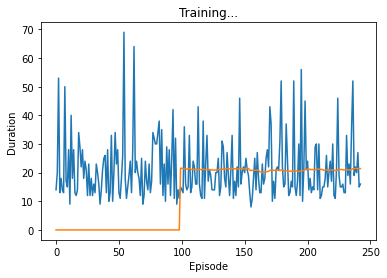

 Episode 243 finished after 12 steps


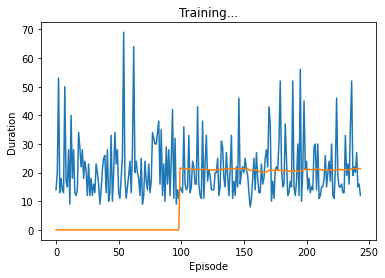

 Episode 244 finished after 32 steps


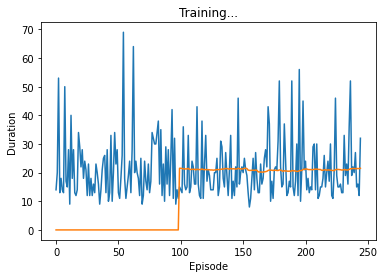

 Episode 245 finished after 14 steps


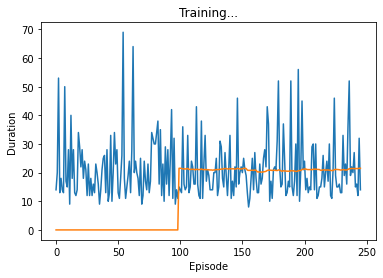

 Episode 246 finished after 22 steps


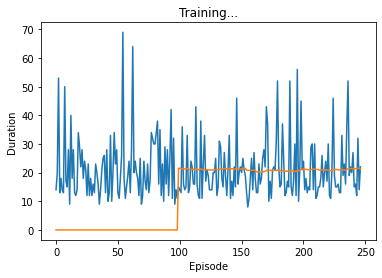

 Episode 247 finished after 16 steps


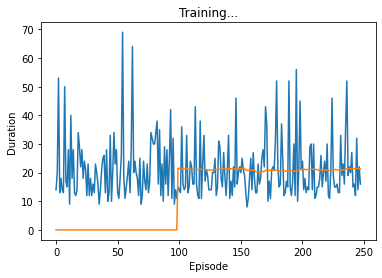

 Episode 248 finished after 23 steps


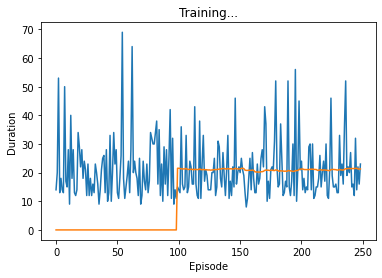

 Episode 249 finished after 17 steps


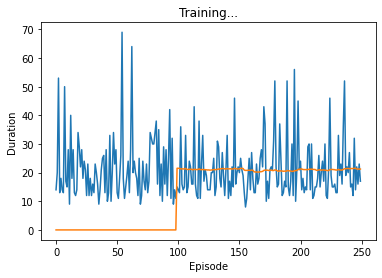

 Episode 250 finished after 12 steps


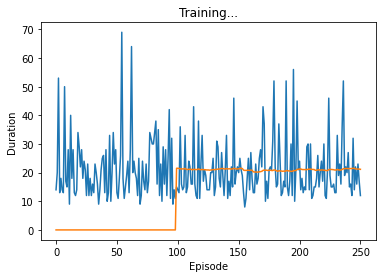

 Episode 251 finished after 16 steps


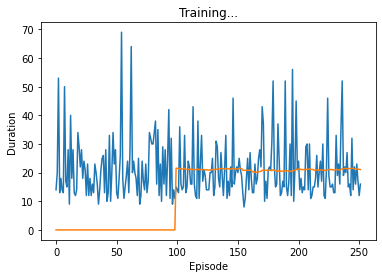

 Episode 252 finished after 31 steps


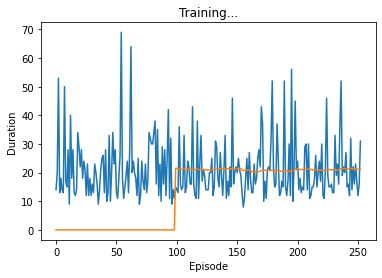

 Episode 253 finished after 11 steps


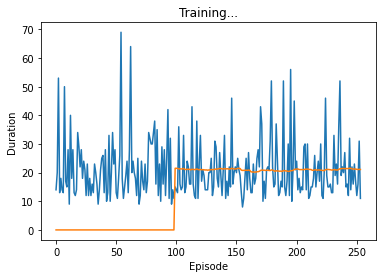

 Episode 254 finished after 10 steps


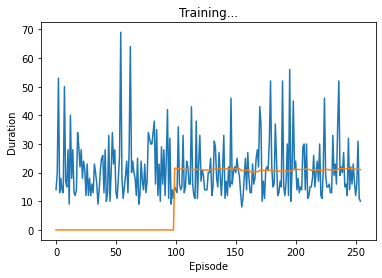

KeyboardInterrupt: 

In [10]:
for e in range(Episodes):
    run_episode(e, env)

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()